# Introduction to Bayesian Regression Analysis

We will review Frequentist regression first and then learn the Bayesian methods. This will help us understand the basic frameworks in both approaches. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# packages for frequentist regression
import statsmodels.api as sm
# package for bayesian regression
import pystan

In [2]:
# read .csv to Python dataframe
# also can be loaded from sklearn.datasets
boston_df = pd.read_csv("Boston.csv") 
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
boston_df.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

# Frequentist Linear Regression

It is always encouraged (actually, necessary) to conduct explatory data analysis before choosing a model. Here we will try a few scatter plots to determine if this data would fit for linear regression model. 

Text(0, 0.5, 'Median of owner-occupied homes ($1000s)')

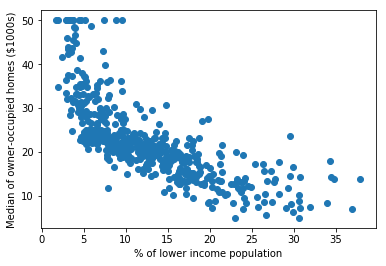

In [4]:
plt.scatter(x=boston_df['lstat'], y=boston_df['medv'])
plt.xlabel('% of lower income population')
plt.ylabel('Median of owner-occupied homes ($1000s)')

Text(0, 0.5, 'Median of owner-occupied homes ($1000s)')

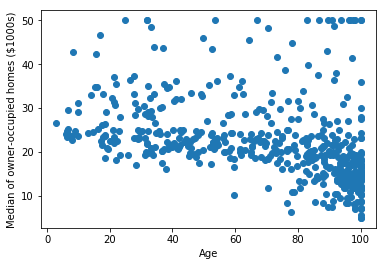

In [5]:
plt.scatter(x=boston_df['age'], y=boston_df['medv'])
plt.xlabel('Age')
plt.ylabel('Median of owner-occupied homes ($1000s)')

In [6]:
# Running linear regression using statsmodels
y = 'medv'
x = ['age', 'lstat']
# Create a design matrix (add one column with 1.0's)
ones = np.ones(boston_df.shape[0])
design_mat = boston_df[x].assign(intercept=ones)
# Add a constant term like so:
boston_fit = sm.OLS(boston_df[y], design_mat).fit()
boston_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Mon, 06 May 2019   Prob (F-statistic):           2.98e-88
Time:                        11:37:42   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0345      0.012      2.826      0.005       0.011       0.059
lstat         -1.0321      0.048    -21.416      0.000      -1.127      -0.937
intercept     33.2228      0.731     45.458      0.000      31.787      34.659
==============================================================================
Omnibus:                      124.288   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.026
Skew:                           1.362   Prob(JB):                     1.02e-53
Kurtosis:                       5.038   Cond. No.                         201.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'residuals')

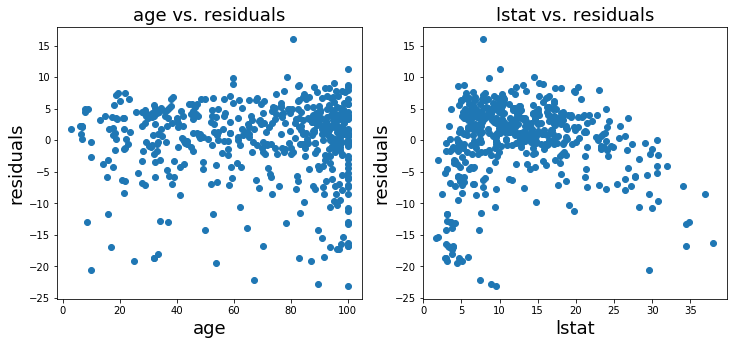

In [7]:
# Calculate resiudals: fitted - observed 
residuals = boston_fit.fittedvalues - boston_df['medv']

# Diagnostic plot: predictor vs. residuals
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.scatter(boston_df['age'], residuals)
ax1.set_title('age vs. residuals', fontsize=18)
ax2.scatter(boston_df['lstat'], residuals)
ax2.set_title('lstat vs. residuals', fontsize=18)
ax1.set_xlabel('age', fontsize=18)
ax1.set_ylabel('residuals', fontsize=18)
ax2.set_xlabel('lstat', fontsize=18)
ax2.set_ylabel('residuals', fontsize=18)

Text(0, 0.5, 'residual')

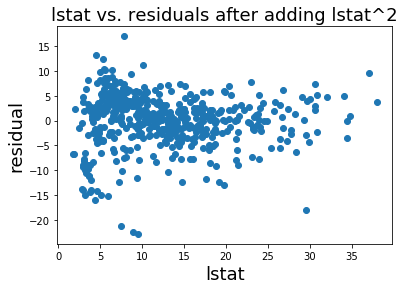

In [8]:
# We can add a squared lstat
lstat2 = np.square(design_mat['lstat'])
design_mat2 = design_mat.assign(lstat2=lstat2)
design_mat2
boston_fit2 = sm.OLS(boston_df[y], design_mat2).fit()
residuals2 = boston_fit2.fittedvalues - boston_df['medv']
plt.scatter(boston_df['lstat'], residuals2)
plt.title('lstat vs. residuals after adding lstat^2', fontsize=18)
plt.xlabel('lstat', fontsize=18)
plt.ylabel('residual', fontsize=18)

Text(0, 0.5, 'fitted medv')

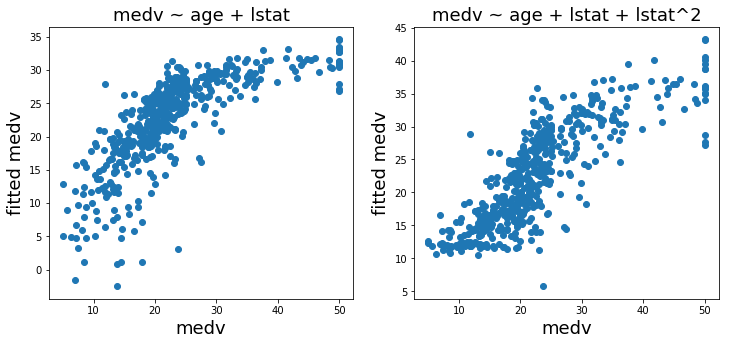

In [9]:
# Diagnostics plot: observed vs. fitted 
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.scatter(boston_df['medv'], boston_fit.fittedvalues)
ax1.set_title('medv ~ age + lstat', fontsize=18)
ax2.scatter(boston_df['medv'], boston_fit2.fittedvalues)
ax2.set_title('medv ~ age + lstat + lstat^2', fontsize=18)
ax1.set_xlabel('medv', fontsize=18)
ax1.set_ylabel('fitted medv', fontsize=18)
ax2.set_xlabel('medv', fontsize=18)
ax2.set_ylabel('fitted medv', fontsize=18)

## Bayesian Linear Regression with PyStan

Seminar slides on Bayesian Regression include the following example.

In [10]:
boston_code = """
data {
  int N;  // number of observations
  vector[N] y;  // response variable
  int K;  // number of columns in the design matrix X
  matrix [N, K] X; // X should not have intercept
  real scale_beta0; // hyperparameter(scale) on beta0
  vector[K] scale_betas; // hyperparameters(scale) on other betas
  real loc_sigma; // hyperparameter(location) on sigma
}
parameters {
  // regression coefficient vector
  real beta0;
  vector[K] betas;
  real sigma;
}
transformed parameters {
  vector[N] mu;
  mu = beta0 + X * betas;
}
model {
  // priors
  beta0 ~ normal(0., scale_beta0);
  betas ~ normal(50., scale_betas);
  sigma ~ exponential(loc_sigma);
  y ~ normal(mu, sigma); // likelihood
}
"""
# list of predictor variables
x = ['age', 'lstat']
boston_dat = {'N': design_mat[x].shape[0],
              'K': 2,
              'y': boston_df['medv'].values,
              'X': design_mat[x].values,
              'scale_beta0': 100,
              'scale_betas': np.array([1, 1]),
              'loc_sigma': 1
}
#
boston_sm = pystan.StanModel(model_code=boston_code)
#
#
boston_bayesfit = boston_sm.sampling(data=boston_dat,
                                     iter=2000,
                                     chains=4,
                                     warmup=500,
                                     thin=5,
                                     seed=2019)
# to summarize results
fit_df = boston_bayesfit.to_dataframe()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0adcb518bef5d791c7f017c8477609d9 NOW.
/anaconda3/envs/introBayesReg/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/rs/r1721d553r9_04l5k_315d6m0000gn/T/tmpfe6zp8cw/stanfit4anon_model_0adcb518bef5d791c7f017c8477609d9_7726951036705269386.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Once you have the large sampled dataset, you summarize the results and interpret them

Text(0, 0.5, 'value')

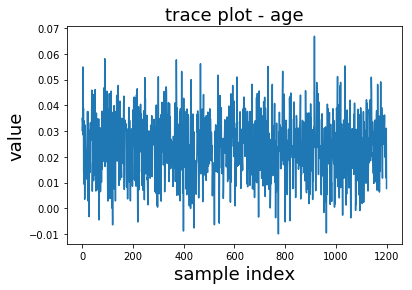

In [11]:
# Traceplots - simply draw index with values
plt.plot(fit_df['betas[1]'])
plt.title('trace plot - age', fontsize=18)
plt.xlabel('sample index', fontsize=18)
plt.ylabel('value', fontsize=18)

Text(0, 0.5, 'Density')

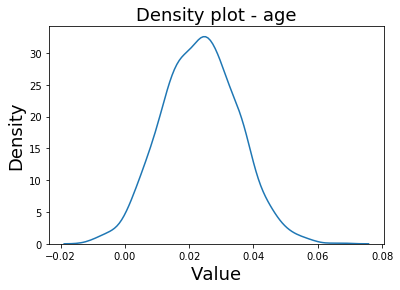

In [12]:
# Also draw density plot for samples
sns.kdeplot(fit_df['betas[1]'], legend=False)
plt.title('Density plot - age', fontsize=18)
plt.xlabel('Value', fontsize=18)
plt.ylabel('Density', fontsize=18)

In [13]:
# posterior parameter distributions
summary_dict = boston_bayesfit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
beta0_mean = df['mean']['beta0']
beta_age_mean = df['mean']['betas[1]']
beta_lstat_mean = df['mean']['betas[2]']
beta0_025 = df['2.5%']['beta0']
beta0_975 = df['97.5%']['beta0']
beta_age_025 = df['2.5%']['betas[1]']
beta_age_975 = df['97.5%']['betas[1]']
beta_lstat_025 = df['2.5%']['betas[2]']
beta_lstat_975 = df['97.5%']['betas[2]']

In [14]:
# print out results
print("beta_age: mean={:.4f} || 2.5% CI={:.4f} || 97.5% CI={:.4f}".format(
    beta_age_mean, beta_age_025, beta_age_975))
print("beta_lstat: mean={:.4f} || 2.5% CI={:.4f} || 97.5% CI={:.4f}".format(
    beta_lstat_mean, beta_lstat_025, beta_lstat_975))
print("intercept: mean={:.4f} || 2.5% CI={:.4f} || 97.5% CI={:.4f}".format(
    beta0_mean, beta0_025, beta0_975))

beta_age: mean=0.0234 || 2.5% CI=0.0015 || 97.5% CI=0.0458
beta_lstat: mean=-0.9280 || 2.5% CI=-1.0197 || 97.5% CI=-0.8315
intercept: mean=32.6651 || 2.5% CI=31.2583 || 97.5% CI=34.0150


sample size: 1200
Mean of posterior Y for given data: 24.3209
Variance of posterior Y: 0.1493


Text(0.5, 1.0, 'Distribution of Y for age=40, lstat=10')

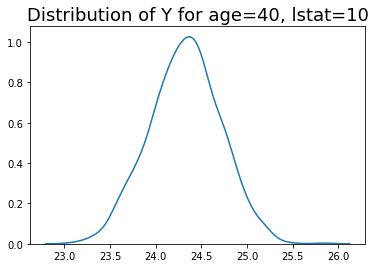

In [15]:
# Posterior predictive distribution
# We need to provide with X values
AGE = 40
LSTAT = 10
y_pred = fit_df['betas[1]'] * AGE + fit_df['betas[2]'] * LSTAT + fit_df['beta0']
print("sample size:", len(y_pred))
print("Mean of posterior Y for given data: {:.4f}".format(np.mean(y_pred)))
print("Variance of posterior Y: {:.4f}".format(np.var(y_pred)))
sns.kdeplot(y_pred)
plt.title('Distribution of Y for age=40, lstat=10', fontsize=18)

# Data for Logistic Regression

In [16]:
# Can use the following for logistic regression
gambia_df = pd.read_csv("gambia.csv") 
gambia_df.head()

,x,y,pos,age,netuse,treated,green,phc
0,349631.3,1458055,1,1783,0,0,40.85,1
1,349631.3,1458055,0,404,1,0,40.85,1
2,349631.3,1458055,0,452,1,0,40.85,1
3,349631.3,1458055,1,566,1,0,40.85,1
4,349631.3,1458055,0,598,1,0,40.85,1


## Reference:
- Boston dataset (R package MASS): https://cran.r-project.org/web/packages/MASS
- gambia dataset (R package geoR): https://cran.r-project.org/web/packages/geoR/index.html
- Stan documentation: https://mc-stan.org/users/documentation/
- PyStan documentation: https://buildmedia.readthedocs.org/media/pdf/pystan/latest/pystan.pdf
- PyStan linear regression: https://jrnold.github.io/bayesian_notes/introduction-to-stan-and-linear-regression.html